Epoch 1/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.3900 - loss: 0.9962 - val_accuracy: 0.8571 - val_loss: 0.4397
Epoch 2/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7447 - loss: 0.4817 - val_accuracy: 0.8901 - val_loss: 0.3355
Epoch 3/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8438 - loss: 0.3746 - val_accuracy: 0.8901 - val_loss: 0.2955
Epoch 4/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8940 - loss: 0.3046 - val_accuracy: 0.9231 - val_loss: 0.2699
Epoch 5/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9033 - loss: 0.2781 - val_accuracy: 0.9451 - val_loss: 0.2476
Epoch 6/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8980 - loss: 0.2423 - val_accuracy: 0.9451 - val_loss: 0.2286
Epoch 7/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8972 - loss: 0.2351 - val_accuracy: 0.9451 - val_loss: 0.2142
Epoch 8/40
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9293 - loss: 0.2035 - val_accuracy: 0.9451 - v

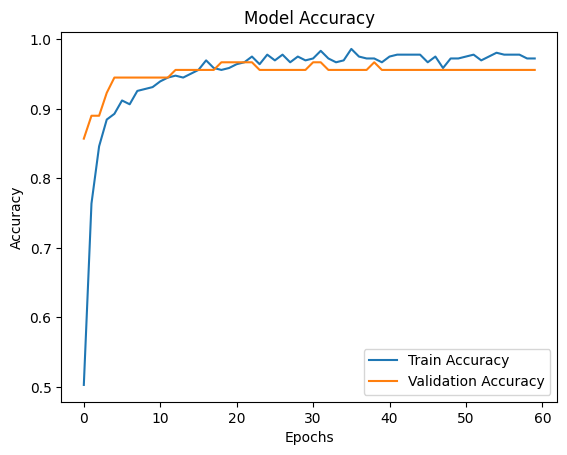

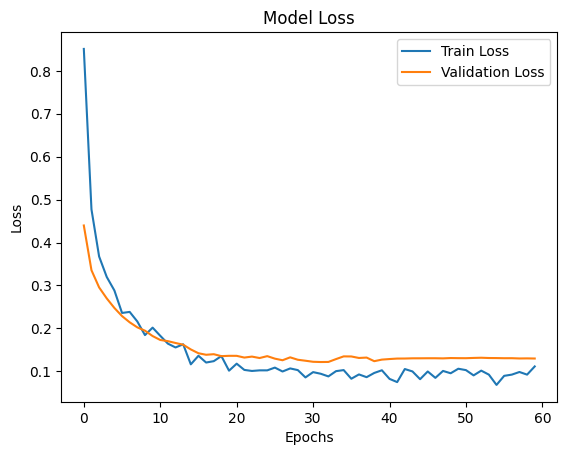

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# load and preprocess dataset
data = pd.read_csv("data.csv")
data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)  # Drop unnecessary columns
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})  # Convert labels to binary

features = [
    'radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'symmetry_mean', 'radius_se', 'concave points_se', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'symmetry_worst', 'fractal_dimension_worst'
]

X = data[features]
y = data['diagnosis']

# training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ANN architechture
def create_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),  # Input layer
        Dense(64, activation='relu'),     # First hidden layer
        Dropout(dropout_rate),            # Dropout for regularization
        Dense(32, activation='relu'),     # Second hidden layer
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')    # Output layer for binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# initial lr and training 
learning_rate = 0.001
dropout_rate = 0.3
model = create_model(learning_rate=learning_rate, dropout_rate=dropout_rate)

history_phase_1 = model.fit(
    X_train, y_train,
    epochs=40,           
    batch_size=32,       
    validation_split=0.2, 
    verbose=1           
)

# update lr and more training 
print("Updating learning rate to 0.0001")
model.optimizer.learning_rate.assign(0.0001)

history_phase_2 = model.fit(
    X_train, y_train,
    epochs=60,          
    batch_size=32,       
    validation_split=0.2,
    verbose=1,          
    initial_epoch=40    
)

# combine
history = {
    'accuracy': history_phase_1.history['accuracy'] + history_phase_2.history['accuracy'],
    'val_accuracy': history_phase_1.history['val_accuracy'] + history_phase_2.history['val_accuracy'],
    'loss': history_phase_1.history['loss'] + history_phase_2.history['loss'],
    'val_loss': history_phase_1.history['val_loss'] + history_phase_2.history['val_loss']
}

# evaluate test set 
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

# metrics 
y_pred_probs = model.predict(X_test).flatten()  
y_pred = (y_pred_probs > 0.5).astype(int)      

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Benign", "Malignant"]))

# AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"AUC-ROC: {roc_auc:.4f}")

# plot accuracy
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot loss
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
